In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_theme(style="whitegrid")
import matplotlib.pyplot as plt
%matplotlib inline

import datetime
import os
import cv2

import tensorflow as tf
from tensorflow.keras.optimizers import Adam, RMSprop, SGD

from keras import regularizers
from keras.layers import Conv2D, Dense, BatchNormalization, Activation, Dropout, MaxPooling2D, Flatten
from keras.callbacks import ModelCheckpoint, CSVLogger, TensorBoard, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from keras.utils.vis_utils import plot_model

from sklearn.metrics import classification_report, confusion_matrix

main_accent_colour = "#b366ff"
dim_colour="darkgrey"
main_palette = ["#FBE5C0", "#DD9A30", "#F88379", "#FF6FC2", "purple", "#D086F6", "#B0D2C2", "#4C5D70", "#6FA2CE", "#382D24", "#3ACF3A", "#7D7D00"]

In [2]:
train_dir = 'train/'
test_dir = 'test/'
row = 48
col = 48
classes = len(os.listdir('train/'))

In [3]:
print('Train Directory :')
print(os.listdir('train/'))

Train Directory :
['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']


In [4]:
print("Test_Directory :")
print(os.listdir('train/'))

Test_Directory :
['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']


In [5]:
def Classes_Count( path, name):
    Classes_Dict = {}
    for Class in os.listdir(path):
        Full_Path = path + Class
        Classes_Dict[Class] = len(os.listdir(Full_Path))
    df = pd.DataFrame(Classes_Dict, index=[name])
    return df
Train_Count = Classes_Count(train_dir, 'Train').transpose().sort_values(by="Train", ascending=False)
Test_Count = Classes_Count(test_dir, 'Test').transpose().sort_values(by="Test", ascending=False)

In [6]:
pd.concat([Train_Count,Test_Count] , axis=1)

,Train,Test
happy,7215,1774
neutral,4965,1233
sad,4830,1247
fear,4097,1024
angry,3995,958
surprise,3171,831
disgust,436,111


<AxesSubplot:>

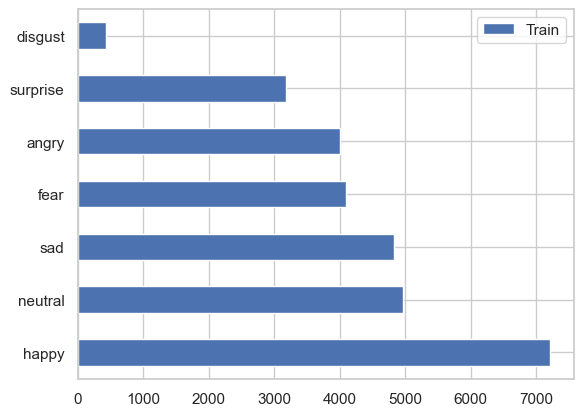

In [7]:
Train_Count.plot(kind='barh')

<AxesSubplot:>

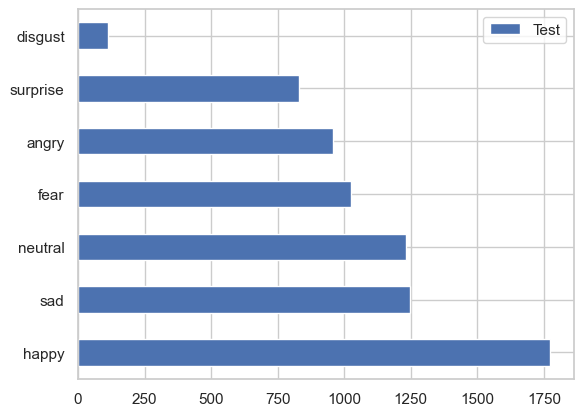

In [8]:
Test_Count.plot(kind='barh')

In [9]:
print("Train Set :")

train_count = []
for folder in os.listdir(train_dir) :
    print(folder, "folder contains\t\t", len(os.listdir(train_dir+folder)), "image")
    train_count.append(len(os.listdir(train_dir+folder)))
    
print()

test_count = []
print("Test Set :")
for folder in os.listdir(test_dir) :
    print(folder, "folder contains\t\t", len(os.listdir(test_dir+folder)), "images")
    test_count.append(len(os.listdir(test_dir+folder)))

Train Set :
angry folder contains		 3995 image
disgust folder contains		 436 image
fear folder contains		 4097 image
happy folder contains		 7215 image
neutral folder contains		 4965 image
sad folder contains		 4830 image
surprise folder contains		 3171 image

Test Set :
angry folder contains		 958 images
disgust folder contains		 111 images
fear folder contains		 1024 images
happy folder contains		 1774 images
neutral folder contains		 1233 images
sad folder contains		 1247 images
surprise folder contains		 831 images


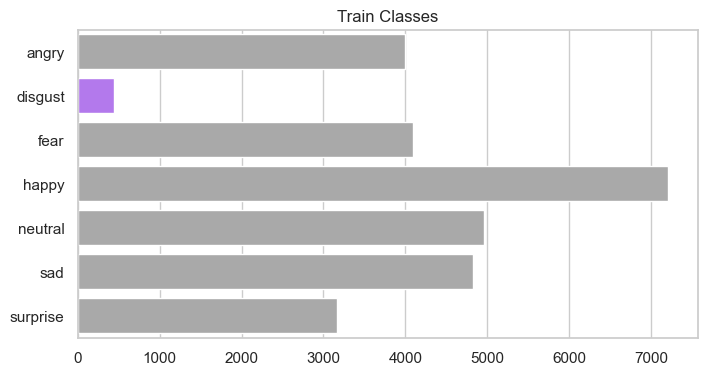

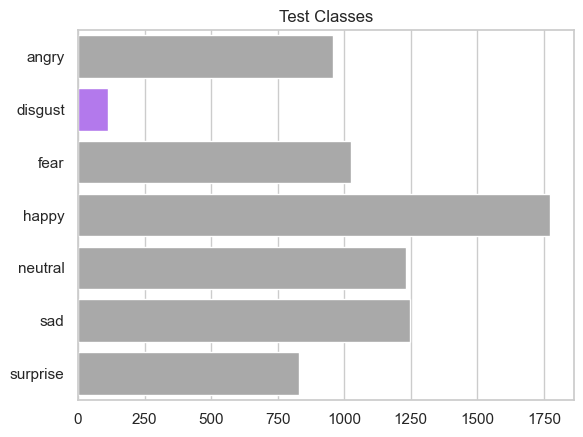

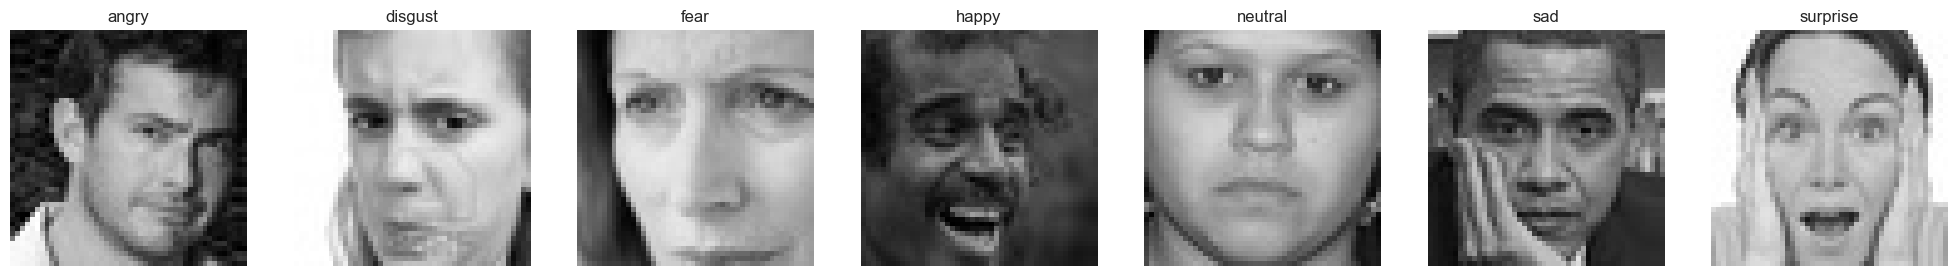

In [10]:
vals = ["disgust"]
palette = {c: dim_colour if c not in vals else main_accent_colour for c in os.listdir(train_dir)}

plt.figure(figsize=(8,4))

ax = sns.barplot(y=os.listdir(train_dir),
                 x=train_count,
                 palette=palette,
                 orientation="horizontal",
).set(title='Train Classes')

plt.show()

print()

ax = sns.barplot(y=os.listdir(test_dir),
                 x=test_count,
                 palette=palette,
                 orientation="horizontal",
).set(title='Test Classes')

plt.show()

print()

plt.figure(figsize=(25,25))

i = 1
for folder in os.listdir(train_dir):
    
    img = load_img((train_dir + folder +'/'+ os.listdir(train_dir + folder)[1]))
    plt.subplot(1,7,i)
    plt.imshow(img)
    plt.title(folder)
    plt.axis('off')
    i += 1
    
plt.show()

In [11]:
import matplotlib.pyplot as plt
%matplotlib inline 

In [12]:
def plot_images(img_dir, top=10):
    all_img_dirs = os.listdir(img_dir)
    img_files = [os.path.join(img_dir, file) for file in all_img_dirs][:5]
    plt.figure(figsize=(10, 10))
    for idx, img_path in enumerate(img_files):
        plt.subplot(5, 5, idx+1)
        img = plt.imread(img_path)
        plt.tight_layout()         
        plt.imshow(img, cmap='gray')

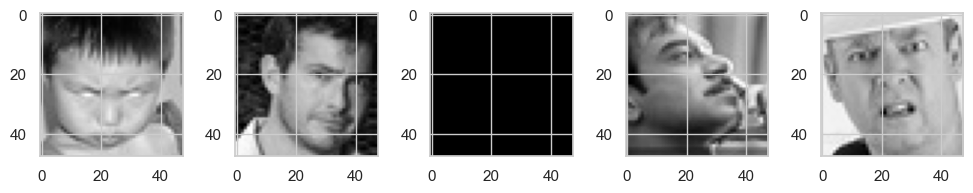

In [13]:
plot_images(train_dir+"/"+"angry")

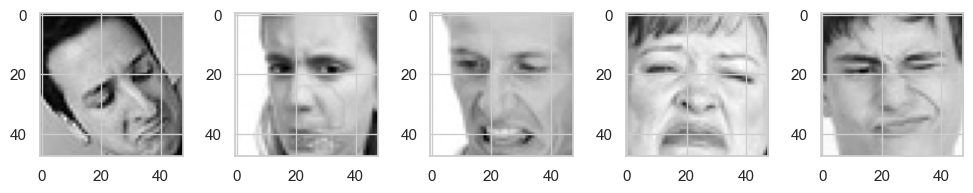

In [14]:
plot_images(train_dir+"/"+"disgust")

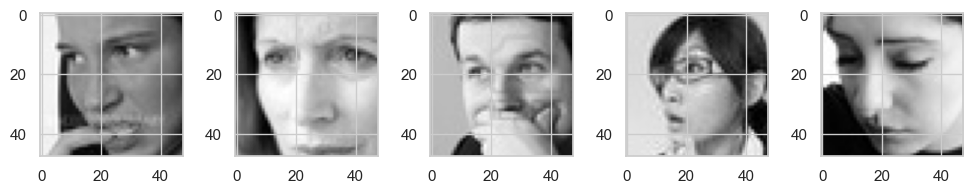

In [15]:
plot_images(train_dir+"/"+"fear")

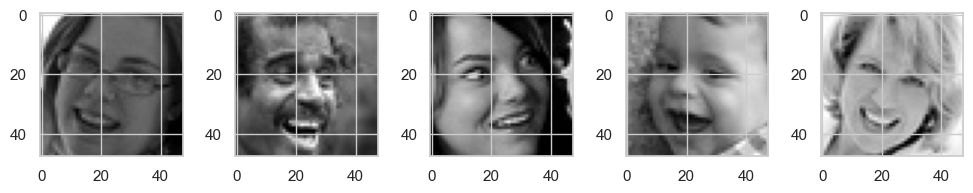

In [16]:
plot_images(train_dir+"/"+"happy")

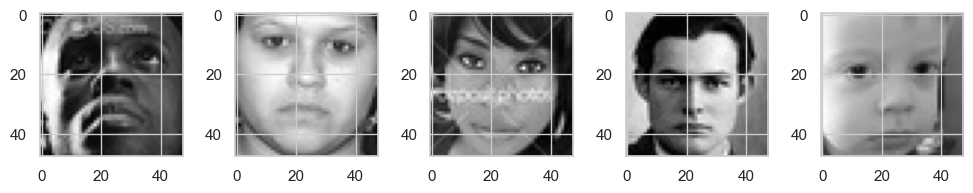

In [17]:
plot_images(train_dir+"/"+"neutral")

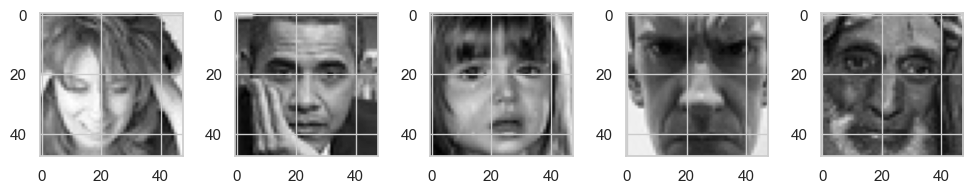

In [18]:
plot_images(train_dir+"/"+"sad")

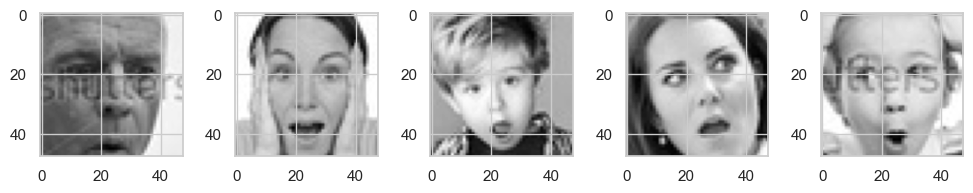

In [19]:
plot_images(train_dir+"/"+"surprise")

In [20]:
train_datagen = ImageDataGenerator(rescale=1./255,
                                   zoom_range=0.3,
                                   horizontal_flip=True)

training_set = train_datagen.flow_from_directory(train_dir,
                                                batch_size=64,
                                                target_size=(48,48),
                                                shuffle=True,
                                                color_mode='grayscale',
                                                class_mode='categorical')

test_datagen = ImageDataGenerator(rescale=1./255)
test_set = test_datagen.flow_from_directory(test_dir,
                                                batch_size=64,
                                                target_size=(48,48),
                                                shuffle=True,
                                                color_mode='grayscale',
                                                class_mode='categorical')

Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


In [21]:
training_set.class_indices

{'angry': 0,
 'disgust': 1,
 'fear': 2,
 'happy': 3,
 'neutral': 4,
 'sad': 5,
 'surprise': 6}

In [22]:
def get_model(input_size, classes=7):
    
    model = tf.keras.models.Sequential()   

    model.add(Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu', input_shape =input_size))
    model.add(Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(2, 2))
    model.add(Dropout(0.25))

    model.add(Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.01)))
    model.add(Conv2D(256, kernel_size=(3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.01)))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Flatten())
    model.add(Dense(1024, activation='relu'))
    model.add(Dropout(0.5))
    
    model.add(Dense(classes, activation='softmax'))

    model.compile(optimizer=Adam(lr=0.0001), 
                  loss='categorical_crossentropy', 
                  metrics=['accuracy'])
    return model

In [23]:
fernet = get_model((row, col, 1), classes)
optimizer = Adam(learning_rate=0.001)  # Adjust the learning rate as needed
fernet.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

fernet.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 48, 48, 32)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 48, 48, 64)        18496     
                                                                 
 batch_normalization (BatchN  (None, 48, 48, 64)       256       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 24, 24, 64)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 24, 24, 64)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 24, 24, 128)       7

In [24]:
chk_path = 'ferNet.h5'
log_dir = "checkpoint/logs/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

checkpoint = ModelCheckpoint(filepath=chk_path,
                             save_best_only=True,
                             verbose=1,
                             mode='min',
                             moniter='val_accuracy')

earlystop = EarlyStopping(monitor='val_accuracy', 
                          min_delta=0, 
                          patience=3, 
                          verbose=1, 
                          restore_best_weights=True)
                        
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', 
                              factor=0.2, 
                              patience=6, 
                              verbose=1, 
                              min_delta=0.0001)


tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
csv_logger = CSVLogger('training.log')

callbacks = [checkpoint, reduce_lr, csv_logger]
callbacks 

In [ ]:
steps_per_epoch = training_set.n // training_set.batch_size
validation_steps = test_set.n // test_set.batch_size

hist = fernet.fit(x=training_set,
                  validation_data=test_set,
                  epochs=10,
                  callbacks=callbacks,
                  steps_per_epoch=steps_per_epoch,
                  validation_steps=validation_steps)

Epoch 1/10
448/448 [==============================] - ETA: 0s - loss: 5.3223 - accuracy: 0.2375
Epoch 1: val_loss improved from inf to 10.72440, saving model to ferNet.h5
448/448 [==============================] - 812s 2s/step - loss: 5.3223 - accuracy: 0.2375 - val_loss: 10.7244 - val_accuracy: 0.1606 - lr: 0.0010
Epoch 2/10
210/448 [=============>................] - ETA: 6:58 - loss: 2.2098 - accuracy: 0.2596

In [ ]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')

In [ ]:
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')

In [ ]:
train_loss, train_accu = fernet.evaluate(training_set)
test_loss, test_accu = fernet.evaluate(test_set)
print("final train accuracy = {:.2f} , validation accuracy = {:.2f}".format(train_accu*100, test_accu*100))

In [ ]:
y_pred = fernet.predict(training_set)
y_pred = np.argmax(y_pred, axis=1)
class_labels = test_set.class_indices
class_labels = {v:k for k,v in class_labels.items()}

cm_train = confusion_matrix(training_set.classes, y_pred)
print('Confusion Matrix')
print(cm_train)
print('Classification Report')
target_names = list(class_labels.values())
print(classification_report(training_set.classes, y_pred, target_names=target_names))

plt.figure(figsize=(8,8))
plt.imshow(cm_train, interpolation='nearest')
plt.colorbar()
tick_mark = np.arange(len(target_names))
_ = plt.xticks(tick_mark, target_names, rotation=90)
_ = plt.yticks(tick_mark, target_names)

In [ ]:
y_pred = fernet.predict(test_set)
y_pred = np.argmax(y_pred, axis=1)
class_labels = test_set.class_indices
class_labels = {v:k for k,v in class_labels.items()}

cm_test = confusion_matrix(test_set.classes, y_pred)
print('Confusion Matrix')
print(cm_test)
print('Classification Report')
target_names = list(class_labels.values())
print(classification_report(test_set.classes, y_pred, target_names=target_names))

plt.figure(figsize=(8,8))
plt.imshow(cm_test, interpolation='nearest')
plt.colorbar()
tick_mark = np.arange(len(target_names))
_ = plt.xticks(tick_mark, target_names, rotation=90)
_ = plt.yticks(tick_mark, target_names)

In [ ]:
plot_images(test_dir+"/"+"angry")

In [ ]:
plot_images(test_dir+"/"+"disgust")

In [ ]:
plot_images(test_dir+"/"+"fear")

In [ ]:
plot_images(test_dir+"/"+"happy")

In [ ]:
plot_images(test_dir+"/"+"neutral")

In [ ]:
plot_images(test_dir+"/"+"sad")

In [ ]:
plot_images(test_dir+"/"+"surprise")

In [ ]:
mood_music = pd.read_csv("..//data_moods.csv")
mood_music.head()

In [ ]:
mood_music = pd.read_csv("..//data_moods.csv")
mood_music = mood_music[['name','artist','mood']]
mood_music.head()

In [ ]:
from keras.utils import load_img
img = load_img("..//test/angry/PrivateTest_2775163.jpg",target_size = (48,48),color_mode = "grayscale")
img = np.array(img)
plt.imshow(img)
print(img.shape)

In [ ]:
training_set.class_indices
label_dict = ['angry', 'disgust', 'fear','happy', 'neutral', 'sad', 'surprise']

In [ ]:
from keras.utils import img_to_array
test_image = img_to_array(img)
test_image = np.expand_dims(test_image, axis = 0)
result = fernet.predict(test_image)
result[0]

In [ ]:
res = np.argmax(result[0])
res

In [ ]:
print('predicted Label for that image is: {}'.format(label_dict[res]))

In [ ]:
image = cv2.imread('..//test/happy/PrivateTest_10077120.jpg',cv2.IMREAD_GRAYSCALE)
plt.imshow(image,cmap='gray')
plt.show()

In [ ]:
image = cv2.resize(image,(48,48))
img=np.array(image)
img=img.reshape(1,48,48,1)
predict_x=fernet.predict(img) 
result=np.argmax(predict_x,axis=1)
result[0]

In [ ]:
if(result[0]==0 or result[0]==1 or result[0]==2 ):
    #for angery,disgust,fear
    filter1=mood_music['mood']=='Calm'
    f1=mood_music.where(filter1)
    f1=f1.dropna()
    f2 =f1.sample(n=5)
    f2.reset_index(inplace=True)
    display(f2)
if(result[0]==3 or result[0]==4):
    #for happy, neutral
    filter1=mood_music['mood']=='Happy'
    f1=mood_music.where(filter1)
    f1=f1.dropna()
    f2 =f1.sample(n=5)
    f2.reset_index(inplace=True)
    display(f2)
if(result[0]==5):
       #for Sad
    filter1=mood_music['mood']=='Sad'
    f1=mood_music.where(filter1)
    f1=f1.dropna()
    f2 =f1.sample(n=5)
    f2.reset_index(inplace=True)
    display(f2)
if(result[0]==6):
     #for surprise
    filter1=mood_music['mood']=='Energetic'
    f1=mood_music.where(filter1)
    f1=f1.dropna()
    f2 =f1.sample(n=5)
    f2.reset_index(inplace=True)
    display(f2)

In [ ]:
image = cv2.imread('..//test/angry/PrivateTest_39884579.jpg',cv2.IMREAD_GRAYSCALE)
plt.imshow(image,cmap='gray')
plt.show()

In [ ]:
image = cv2.resize(image,(48,48))
img=np.array(image)
img=img.reshape(1,48,48,1)
predict_x=fernet.predict(img) 
result=np.argmax(predict_x,axis=1)
result[0]

In [ ]:
if(result[0]==0 or result[0]==1 or result[0]==2 ):
    
    #for angry,disgust,fear
    filter1=mood_music['mood']=='Calm'
    f1=mood_music.where(filter1)
    f1=f1.dropna()
    f2 =f1.sample(n=5)
    f2.reset_index(inplace=True)
    display(f2)
if(result[0]==3 or result[0]==4):
    
    #for happy, neutral
    filter1=mood_music['mood']=='Happy'
    f1=mood_music.where(filter1)
    f1=f1.dropna()
    f2 =f1.sample(n=5)
    f2.reset_index(inplace=True)
    display(f2)
if(result[0]==5):
    
    #for Sad
    filter1=mood_music['mood']=='Sad'
    f1=mood_music.where(filter1)
    f1=f1.dropna()
    f2 =f1.sample(n=5)
    f2.reset_index(inplace=True)
    display(f2)
if(result[0]==6):
    
    #for surprise
    filter1=mood_music['mood']=='Energetic'
    f1=mood_music.where(filter1)
    f1=f1.dropna()
    f2 =f1.sample(n=5)
    f2.reset_index(inplace=True)
    display(f2)